### Задача Т2

Случайная величина имеет **экспоненциальный** закон распределения

$$
p(x)=
\begin{cases}
e^{-x}, & x \ge 0,\\
0, & x < 0
\end{cases}
$$

Сгенерируйте выборку объема (n = 25).

a)
Определить по выборке моду, медиану, размах, оценку коэффициента асимметрии.

b)
Построить эмпирическую функцию распределения, гистограмму и boxplot.

c)
Сравнить оценку плотности распределения среднего арифметического элементов выборки, полученную с помощью ЦПТ, с бутстраповской оценкой этой плотности.

d)
Найти бутстраповскую оценку плотности распределения коэффициента асимметрии и оценить вероятность того, что коэффициент асимметрии будет меньше 1.

e)
Сравнить плотность распределения медианы выборки с бутстраповской оценкой этой плотности.

## Решение:

Сначала найдем и реализуем необходимые функции.


$$
F(x) = \int_{-\infty}^{x}{p(t)dt} = \int_{0}^{x}{e^{-t}dt} = 1 - e^{-x} \text{ – функция распределения данной случайной величины}

\newline

\mu_k = \frac{1}{n} \sum_{i=1}^{n} \left( x_i - \bar{x} \right)^k, \text{ – k-й центральный момент, где } \

\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i

\newline

N(a, D) = \frac{1}{\sqrt{2 \pi D}} \ exp({-\frac{(x-a)^2}{2D}}) \text{ – функция нормального распределение}
$$

In [11]:
# Импортируем зависимости

import sys
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# Set style for matplotlib
plt.style.use("ggplot")

sys.path.append(os.path.abspath("../../"))

from tools import additionals, visualisation

In [12]:
# Необходимые функции

def p(x):
    return np.exp(-x) if x >= 0 else 0

def F(x):
    return 1 - np.exp(-x) if x >= 0 else 0

def mu_k(sample, k: int) -> float:
    sample_avg = np.mean(sample)
    return np.sum([(sample_i - sample_avg)**k for sample_i in sample]) / len(sample)

def normal(x, a, D):
    return (np.sqrt(2 * np.pi * D))**(-1) * np.exp(-(x-a)**2 / (2*D))

##### Для нашей случайной величины:

$$
\lambda = 1 \text{ – интенсивность простейшего потока (такое название нашёл в интернете)} \\
scale = 1 / \lambda = 1 \text{ – введём параметр, который будем далее использовать}
$$

In [13]:
scale = 1

In [14]:
# Генерируем выборку

np.random.seed(42)      # – для воспроизводимости результатов (опционально – без него будет каждый раз новая выборка)

n = 25                  # – число элементов выборки
X = np.random.exponential(scale=scale, size=n)

X_ordered = np.sort(X)  # – вариационный ряд

print(X)

[0.46926809 3.01012143 1.31674569 0.91294255 0.16962487 0.16959629
 0.05983877 2.01123086 0.91908215 1.23125006 0.02079931 3.50355748
 1.78642954 0.23868763 0.20067899 0.20261142 0.36275373 0.74392783
 0.56553707 0.34422299 0.94637087 0.15023453 0.34551551 0.45627722
 0.60893469]


#### а) Мода, медиана, размах, оценка коэффициента асимметрии.

$$
\gamma = \frac{\mu_3}{\mu_2^{\frac{3}{2}}} \ \text{ – формула для нахождения выборочного коэффициента ассиметрии}
$$

In [15]:
from tabulate import tabulate

values, counts = np.unique(X, return_counts=True)
mode_index = np.argmax(counts)

def find_mode(array):
    values, counts = np.unique(array, return_counts=True)
    max_count = np.max(counts)
    
    if max_count == 1:
        return "Нет моды (все элементы уникальны)"
    
    modes = values[counts == max_count]

    return modes[0]

mode = find_mode(X)                  # – мода
median = np.median(X)               # – медиана
range_val = np.max(X) - np.min(X)   # – размах
gamma = st.skew(X)                  # – оценка коэффициента ассиметрии

table_data = [
    ["Мода", mode],
    ["Медиана", f"{median:.4f}"],
    ["Размах", f"{range_val:.4f}"],
    ["Коэф. асимметрии", f"{gamma:.4f}"]
]

print(tabulate(table_data, 
               headers=["Статистика", "Значение"], 
               tablefmt="fancy_grid",
               colalign=("left", "right")))

╒══════════════════╤═══════════════════════════════════╕
│ Статистика       │                          Значение │
╞══════════════════╪═══════════════════════════════════╡
│ Мода             │ Нет моды (все элементы уникальны) │
├──────────────────┼───────────────────────────────────┤
│ Медиана          │                            0.4693 │
├──────────────────┼───────────────────────────────────┤
│ Размах           │                            3.4828 │
├──────────────────┼───────────────────────────────────┤
│ Коэф. асимметрии │                            1.6998 │
╘══════════════════╧═══════════════════════════════════╛


#### b) Эмпирическая функция распределения, гистограмма и boxplot

##### Начнём с эмпирической функции:

$$
\widetilde{F}(x) = \frac{m(x)}{n}, \ \text{где } m(x) \text{ – число элементов выборки, которые меньше } x
$$

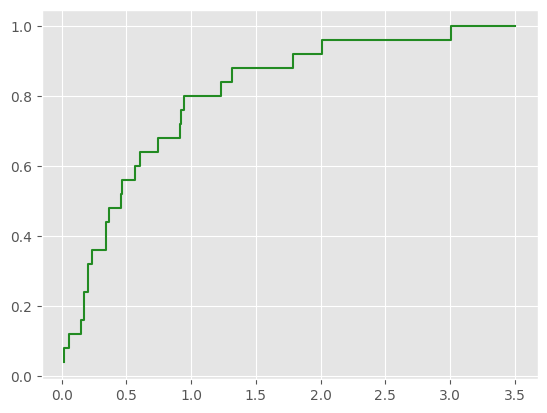

In [16]:
plt.step(
    X_ordered,
    np.arange(1,1+n) / n,
    color='forestgreen',
    linestyle='-'
)
plt.show()

##### Гистограмма

$$
K = 1 + \log_2{n} \ \text{ – правило Стерджесса для определения оптимального числа интервалов гистограммы.}
$$

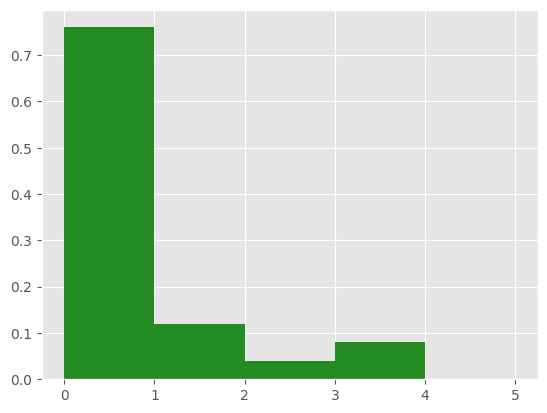

In [26]:
K = int(1 + np.log2(n))

plt.hist(
    X_ordered,
    bins=K,
    range=(0, 5),
    density=True,
    color='forestgreen'
)
plt.show()

##### Boxplot

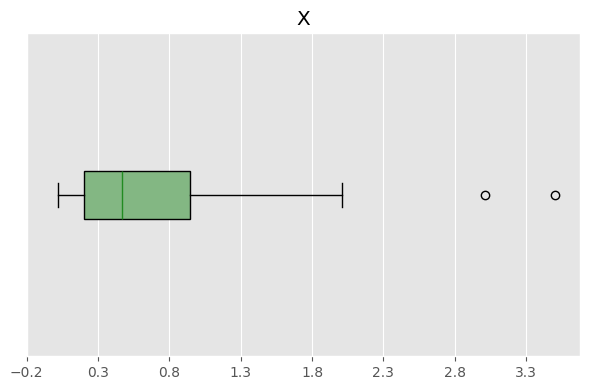

In [18]:
X_ = np.array([X, np.zeros_like(X)]).T

visualisation.visualize_distribution(
    points=X_,
    diagram_type=visualisation.DiagramTypes.Boxplot,
    diagram_axis=visualisation.AxisNames.X
)